In [37]:
!pip install apyori

In [38]:
import pandas as pd 
import numpy as np
import networkx as nx 
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
from PyARMViz import PyARMViz

import missingno as msno
from apyori import apriori
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [39]:
data = pd.read_csv('/kaggle/input/the-bread-basket/bread basket.csv')
data.head()

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


In [41]:
data.describe()

,Transaction
count,20507.000000
mean,4976.202370
std,2796.203001
min,1.000000
25%,2552.000000
50%,5137.000000
75%,7357.000000
max,9684.000000


In [42]:
data.isnull().sum()

Transaction        0
Item               0
date_time          0
period_day         0
weekday_weekend    0
dtype: int64

In [43]:
data['Transaction'].nunique()

9465

<Axes: >

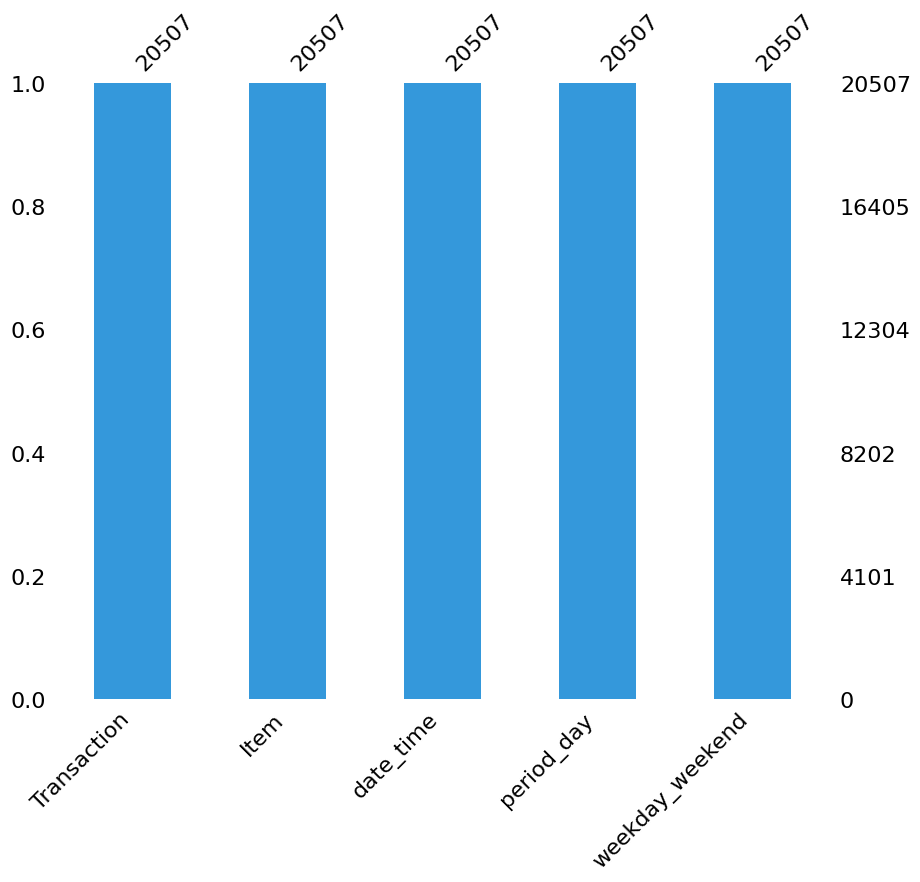

In [44]:
 # Check the missing values in test data
msno.bar(data,color = "#3498db", figsize = (10,8)) 

In [45]:
data['date_time']=pd.to_datetime(data['date_time'])
data['date']=data['date_time'].dt.date
data['time']=data['date_time'].dt.time
data['month']=data['date_time'].dt.month

/tmp/ipykernel_43/2271635049.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['date_time']=pd.to_datetime(data['date_time'])


In [46]:
data['month'] = data['month'].replace((1,2,3,4,5,6,7,8,9,10,11,12), 
                                          ('January','February','March','April','May','June','July','August',
                                          'September','October','November','December'))
data['day']=data['date_time'].dt.weekday
data['day'] = data['day'].replace((0,1,2,3,4,5,6), 
                                          ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))
data['hour']=data['date_time'].dt.hour
data.drop('date_time', axis = 1, inplace = True)
data.head()

,Transaction,Item,period_day,weekday_weekend,date,time,month,day,hour
0,1,Bread,morning,weekend,2016-10-30,09:58:00,October,Sunday,9
1,2,Scandinavian,morning,weekend,2016-10-30,10:05:00,October,Sunday,10
2,2,Scandinavian,morning,weekend,2016-10-30,10:05:00,October,Sunday,10
3,3,Hot chocolate,morning,weekend,2016-10-30,10:07:00,October,Sunday,10
4,3,Jam,morning,weekend,2016-10-30,10:07:00,October,Sunday,10


**Data Visualization**

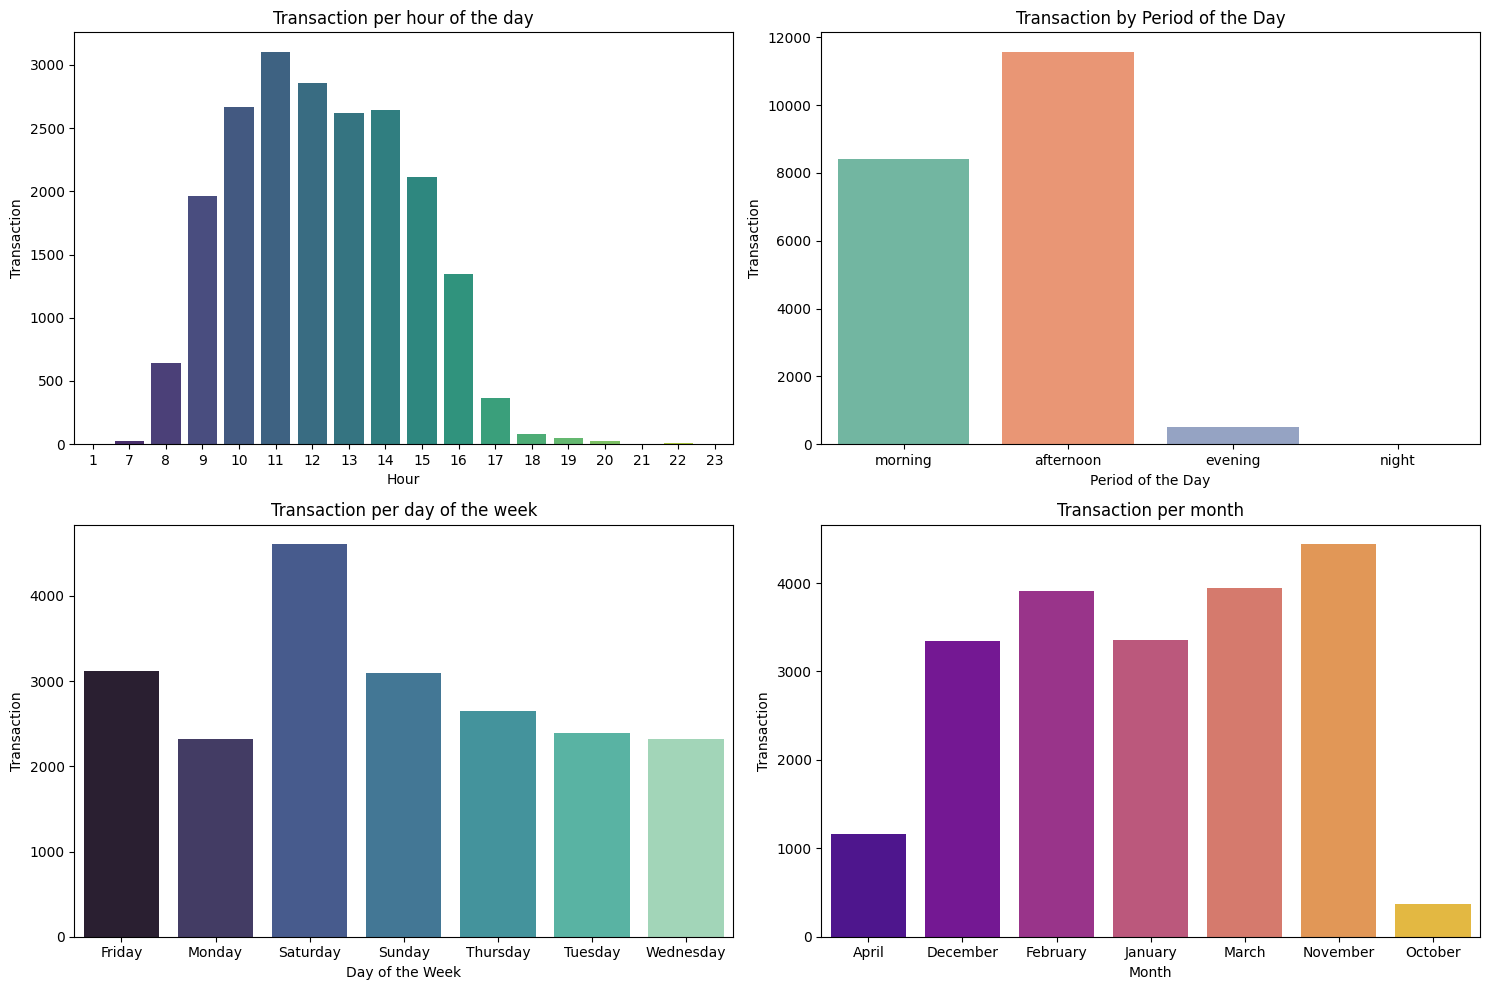

In [47]:
# Set up subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Transaction per hour of the day
coutbyhour = data.groupby('hour')['Transaction'].count().reset_index()
coutbyhour.sort_values('hour', inplace=True)
sns.barplot(x=coutbyhour['hour'], y=coutbyhour['Transaction'], ax=axs[0, 0], palette='viridis')
axs[0, 0].set(xlabel='Hour', ylabel='Transaction', title='Transaction per hour of the day')

# Plot 2: Transaction by period of the day
coutbyweekday = data['period_day'].value_counts().reindex(['morning', 'afternoon', 'evening', 'night'])
sns.barplot(x=coutbyweekday.index, y=coutbyweekday.values, ax=axs[0, 1], palette='Set2')
axs[0, 1].set(xlabel='Period of the Day', ylabel='Transaction', title='Transaction by Period of the Day')

# Plot 3: Transaction per day of the week
coutbydayp = data.groupby('day')['Transaction'].count().reset_index()
coutbydayp.sort_values('day', inplace=True)
sns.barplot(x=coutbydayp['day'], y=coutbydayp['Transaction'], ax=axs[1, 0], palette='mako')
axs[1, 0].set(xlabel='Day of the Week', ylabel='Transaction', title='Transaction per day of the week')

# Plot 4: Transaction per month
coutbymonth = data.groupby('month')['Transaction'].count().reset_index()
coutbymonth.sort_values('month', inplace=True)
sns.barplot(x=coutbymonth['month'], y=coutbymonth['Transaction'], ax=axs[1, 1], palette='plasma')
axs[1, 1].set(xlabel='Month', ylabel='Transaction', title='Transaction per month')

# Adjust layout
plt.tight_layout()
plt.show()


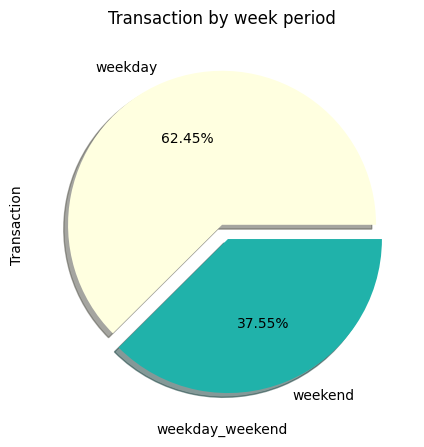

In [52]:
import matplotlib.pyplot as plt

size = [12807, 7700]
labels = "weekday", "weekend"
colors = ["lightyellow", "lightseagreen"]  # Different color scheme
explode = [0, 0.1]

plt.figure(figsize=(12, 5))
plt.pie(size, labels=labels, colors=colors, explode=explode, shadow=True, autopct="%.2f%%")
plt.xlabel('weekday_weekend')
plt.ylabel('Transaction')
plt.title('Transaction by week period')
plt.show()


**Top sold product**

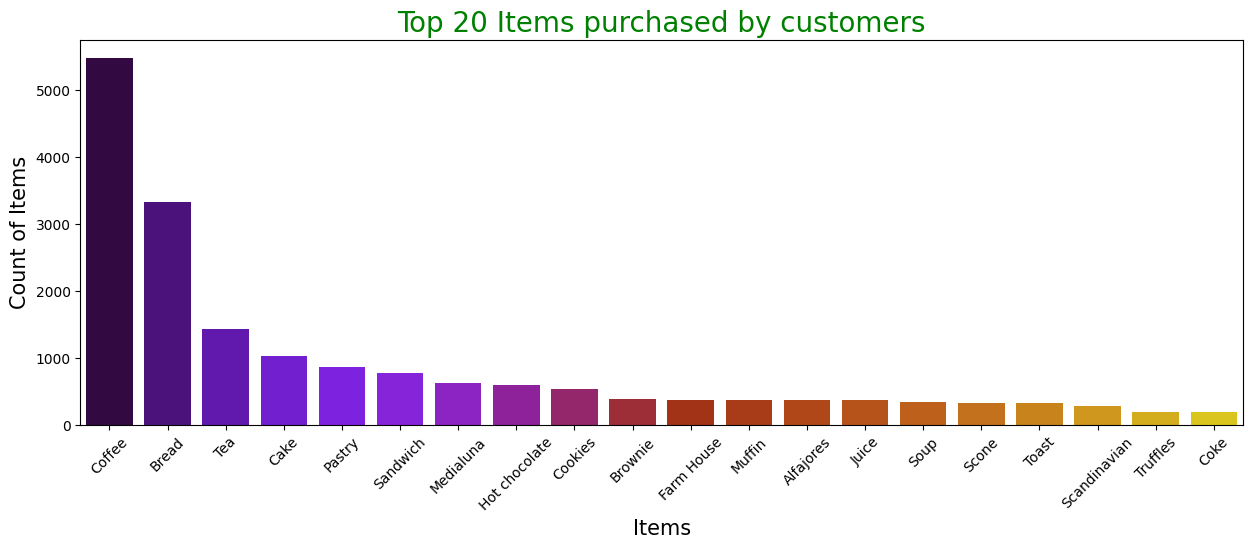

In [55]:
plt.figure(figsize=(15,5))
sns.barplot(x = data.Item.value_counts().head(20).index, y = data.Item.value_counts().head(20).values, palette = 'gnuplot')
plt.xlabel('Items', size = 15)
plt.xticks(rotation=45)
plt.ylabel('Count of Items', size = 15)
plt.title('Top 20 Items purchased by customers', color = 'green', size = 20)
plt.show()

**Apriori Algorithm**

In [56]:
from mlxtend.frequent_patterns import association_rules, apriori
transactions = data.groupby(['Transaction', 'Item'])['Item'].count().reset_index(name ='Count')
transactions

,Transaction,Item,Count
0,1,Bread,1
1,2,Scandinavian,2
2,3,Cookies,1
3,3,Hot chocolate,1
4,3,Jam,1
...,...,...,...
18882,9682,Tacos/Fajita,1
18883,9682,Tea,1
18884,9683,Coffee,1
18885,9683,Pastry,1


In [58]:
table = transactions.pivot_table(index='Transaction', columns='Item', values='Count', aggfunc='sum').fillna(0)
table.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
# making a function which returns 0 or 1
# 0 means item was not in that transaction, 1 means item present in that transaction
def hot_encode(x): 
    if(x==0): 
        return 0
    if(x>0): 
        return 1

In [61]:
# applying the function to the dataset
final_table=table.applymap(hot_encode)
final_table.head()

Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# frequent itemset
frequence = apriori(final_table, min_support=0.015, use_colnames=True)
rules = association_rules(frequence, metric="lift", min_threshold=1)

/opt/conda/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [63]:
# now making the rules from frequent itemset generated above
rules.sort_values('confidence', ascending = False, inplace=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
27,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
16,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
20,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
0,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
14,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919,0.108738
23,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384,0.109205
6,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
24,(Scone),(Coffee),0.034548,0.478394,0.018067,0.522936,1.093107,0.001539,1.093366,0.088224
10,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174,0.081700
13,(Hot chocolate),(Coffee),0.058320,0.478394,0.029583,0.507246,1.060311,0.001683,1.058553,0.060403


In [64]:
# arranging the data from highest to lowest with respect to 'confidence'
rules.sort_values('confidence', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
27,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
16,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
20,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
0,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
14,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919,0.108738
23,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384,0.109205
6,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
24,(Scone),(Coffee),0.034548,0.478394,0.018067,0.522936,1.093107,0.001539,1.093366,0.088224
10,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174,0.081700
13,(Hot chocolate),(Coffee),0.058320,0.478394,0.029583,0.507246,1.060311,0.001683,1.058553,0.060403
